In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


In [3]:
demographic_df = pd.read_csv('./demographic_info.csv', delimiter=',')
nRow, nCol = demographic_df.shape
print(f'There are {nRow} rows and {nCol} columns')
print(f'Missing Values: \n{demographic_df.isnull().sum()}')
demographic_df.head()

There are 10 rows and 4 columns
Missing Values: 
subject ID    0
 age          0
 ethnicity    0
 gender       0
dtype: int64


,subject ID,age,ethnicity,gender
0,0,25,Han Chinese,M
1,1,24,Han Chinese,M
2,2,31,English,M
3,3,28,Han Chinese,F
4,4,24,Bengali,M


In [5]:
eeg_df = pd.read_csv('./EEG_data.csv', delimiter=',')
nRow, nCol = eeg_df.shape
print(f'There are {nRow} rows and {nCol} columns')
print(f'Missing Values: \n{eeg_df.isnull().sum()}')
eeg_df.head()

There are 12811 rows and 15 columns
Missing Values: 
SubjectID             0
VideoID               0
Attention             0
Mediation             0
Raw                   0
Delta                 0
Theta                 0
Alpha1                0
Alpha2                0
Beta1                 0
Beta2                 0
Gamma1                0
Gamma2                0
predefinedlabel       0
user-definedlabeln    0
dtype: int64


,SubjectID,VideoID,Attention,Mediation,Raw,Delta,Theta,Alpha1,Alpha2,Beta1,Beta2,Gamma1,Gamma2,predefinedlabel,user-definedlabeln
0,0.0,0.0,56.0,43.0,278.0,301963.0,90612.0,33735.0,23991.0,27946.0,45097.0,33228.0,8293.0,0.0,0.0
1,0.0,0.0,40.0,35.0,-50.0,73787.0,28083.0,1439.0,2240.0,2746.0,3687.0,5293.0,2740.0,0.0,0.0
2,0.0,0.0,47.0,48.0,101.0,758353.0,383745.0,201999.0,62107.0,36293.0,130536.0,57243.0,25354.0,0.0,0.0
3,0.0,0.0,47.0,57.0,-5.0,2012240.0,129350.0,61236.0,17084.0,11488.0,62462.0,49960.0,33932.0,0.0,0.0
4,0.0,0.0,44.0,53.0,-8.0,1005145.0,354328.0,37102.0,88881.0,45307.0,99603.0,44790.0,29749.0,0.0,0.0


# Scaling and Preprocessing

### Why not StandardScaler?
Use MinMaxScaler for EEG data with LSTMs because EEG signals often have non-Gaussian distributions and temporal dependencies are preserved.

### Why Sequence Data?
By organizing EEG data into sequences, you allow the LSTM to learn patterns, trends, and relationships that span across time steps.

LSTMs require input as a 3D array with the shape:

(num_sequences,sequence_length,num_features)

In [17]:
eeg_features = ['Attention', 'Mediation', 'Raw', 'Delta', 'Theta', 
                'Alpha1', 'Alpha2', 'Beta1', 'Beta2', 'Gamma1', 'Gamma2']
scaler = MinMaxScaler()

eeg_df_normalized = eeg_df.copy()
eeg_df_normalized[eeg_features] = scaler.fit_transform(eeg_df[eeg_features])
sequence_length = 50  # Number of time steps in each sequence
X = []
y = []

for subject_id, video_id in eeg_df_normalized.groupby(['SubjectID', 'VideoID']):
    subject_video_data = video_id[eeg_features].values 
    labels = video_id['user-definedlabeln'].values
    
    # Create overlapping sequences
    for i in range(len(subject_video_data) - sequence_length + 1):
        X.append(subject_video_data[i:i+sequence_length])
        y.append(labels[i+sequence_length-1])

X = np.array(X)
y = np.array(y)

print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}") 

Shape of X: (7911, 50, 11)
Shape of y: (7911,)


***Important NOT to shuffle here***

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [37]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, accuracy_score

In [41]:
# Define the LSTM model
model = Sequential([
    Input((50,11)),
    LSTM(64, return_sequences=True),
    Dropout(0.3),
    LSTM(32, return_sequences=False), 
    Dropout(0.3),
    Dense(16, activation='relu'), 
    Dense(1, activation='sigmoid') 
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 50, 64)         │        19,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,417 (126.63 KB)

 Trainable params: 32,417 (126.63 KB)

 Non-trainable params: 0 (0.00 B)

In [43]:
history = model.fit(
    X_train, y_train,
    epochs=20, 
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

Epoch 1/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.5619 - loss: 0.6706 - val_accuracy: 0.7346 - val_loss: 0.5656
Epoch 2/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.6953 - loss: 0.5786 - val_accuracy: 0.7409 - val_loss: 0.5439
Epoch 3/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7214 - loss: 0.5543 - val_accuracy: 0.7480 - val_loss: 0.5211
Epoch 4/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7372 - loss: 0.5376 - val_accuracy: 0.7299 - val_loss: 0.5249
Epoch 5/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7419 - loss: 0.5324 - val_accuracy: 0.7607 - val_loss: 0.4839
Epoch 6/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7463 - loss: 0.5092 - val_accuracy: 0.7930 - val_loss: 0.4547
Epoch 7/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7736 - loss: 0.4658 - val_accuracy: 0.8002 - val_loss: 0.4296
Epoch 8/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7654 - loss: 0.4817 - val_accu

In [45]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Predictions and Classification Report
y_pred = (model.predict(X_test) > 0.5).astype("int32")

Test Accuracy: 0.8939
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


**89% Accuracy**

Why?

LSTMs are well-suited to capturing temporal dependencies in EEG data.
Preprocessing retained the sequence structure, allowing the LSTM to learn meaningful patterns.
Careful architecture design and hyperparameter choices helped the model generalize effectively.

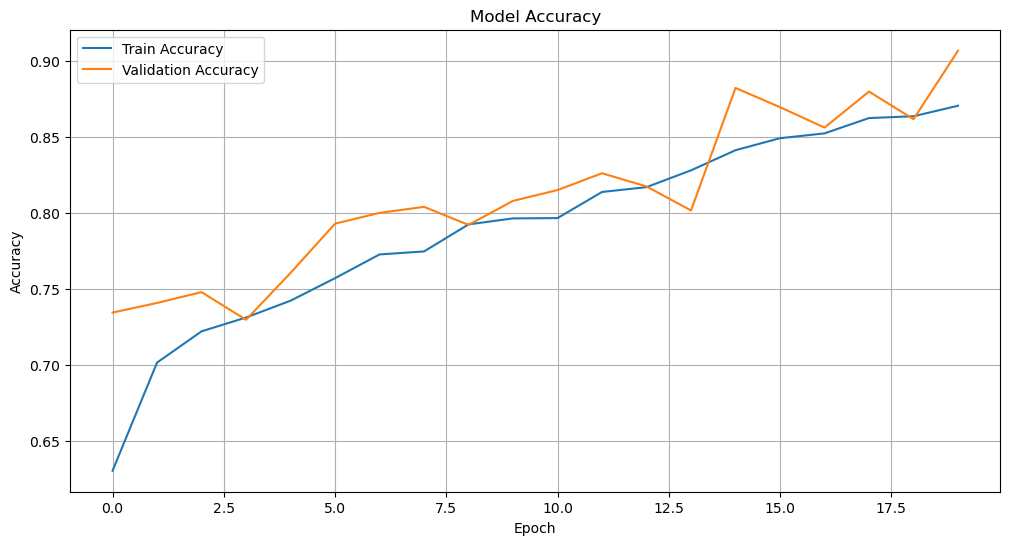

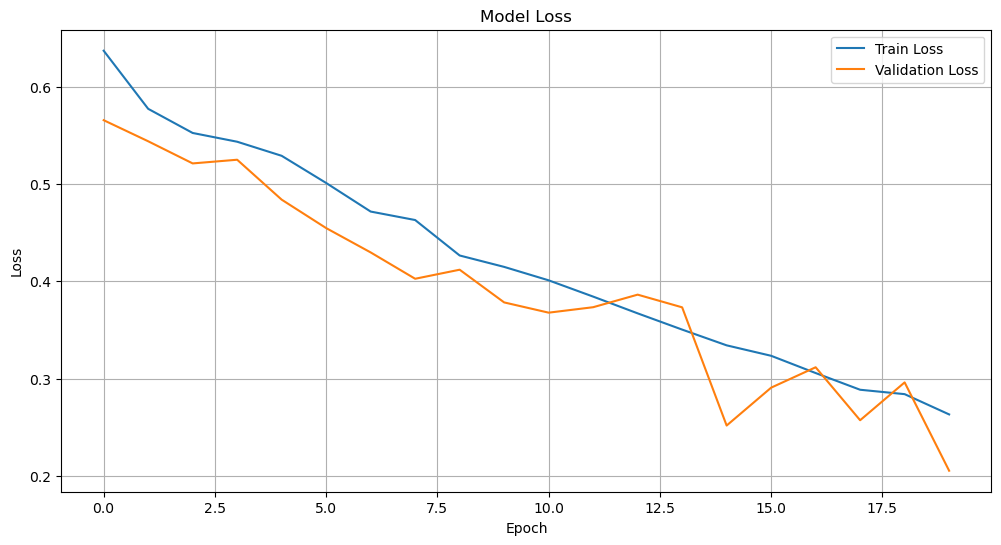

In [47]:
# Plot training & validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot training & validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# CNN

This might be used for spatial data, but it should also be able to pick up temporal patterns

In [56]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Input
from sklearn.metrics import classification_report, accuracy_score

In [58]:
# Define the CNN model
model = Sequential([
    Input((50, 11)),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2), 
    Dropout(0.3),
    
    Conv1D(filters=32, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid') 
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 48, 64)         │         2,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 22, 32)         │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 11, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 11, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 352)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │        22,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,009 (121.13 KB)

 Trainable params: 31,009 (121.13 KB)

 Non-trainable params: 0 (0.00 B)

In [60]:
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32, 
    validation_split=0.2,
    verbose=1
)

Epoch 1/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5858 - loss: 0.6631 - val_accuracy: 0.7054 - val_loss: 0.5873
Epoch 2/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6986 - loss: 0.5820 - val_accuracy: 0.7306 - val_loss: 0.5489
Epoch 3/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7106 - loss: 0.5608 - val_accuracy: 0.7393 - val_loss: 0.5059
Epoch 4/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7316 - loss: 0.5252 - val_accuracy: 0.7567 - val_loss: 0.5131
Epoch 5/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7428 - loss: 0.5127 - val_accuracy: 0.7970 - val_loss: 0.4613
Epoch 6/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7884 - loss: 0.4472 - val_accuracy: 0.8065 - val_loss: 0.4047
Epoch 7/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8172 - loss: 0.3990 - val_accuracy: 0.8341 - val_loss: 0.3876
Epoch 8/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8185 - loss: 0.3681 - val_accuracy: 0.

In [62]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")
y_pred = (model.predict(X_test) > 0.5).astype("int32")

Test Accuracy: 0.9520
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step


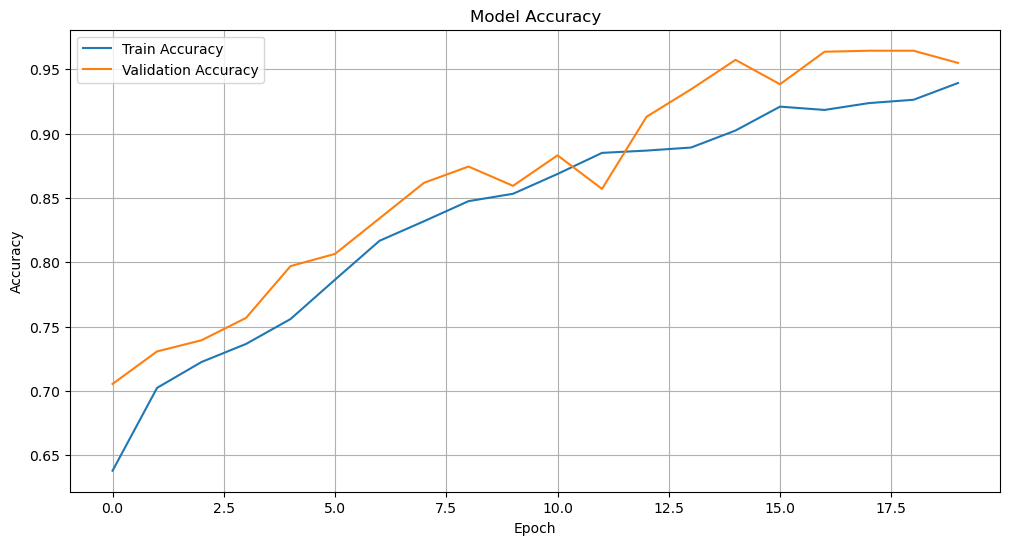

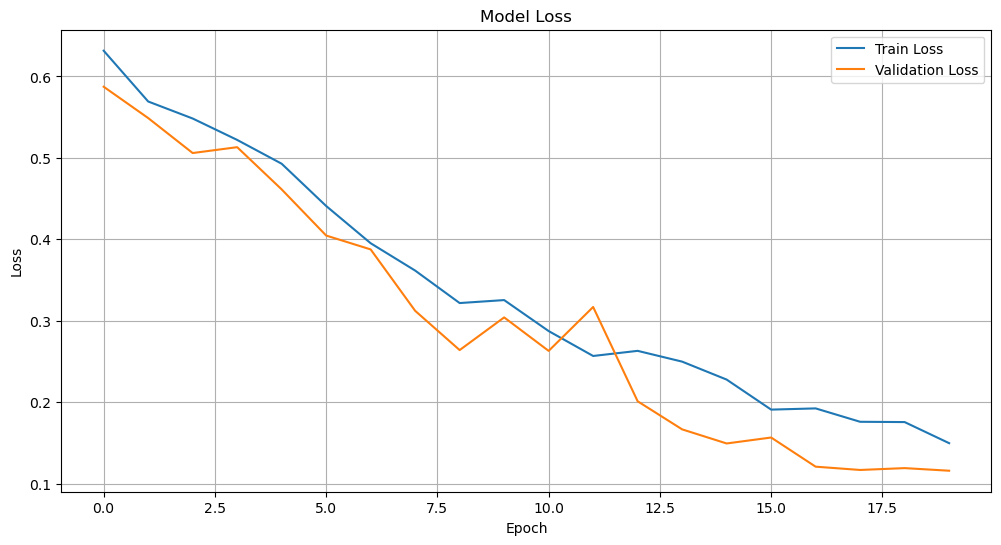

In [64]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot training & validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()